# Download of the Dataset

In [1]:
# Import libraries
import os
import numpy as np
import pandas as pd
import random
import tensorflow as tf

random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

In [2]:
cwd = '/content'
zip_url = 'https://archive.ics.uci.edu/static/public/240/human+activity+recognition+using+smartphones.zip'
zip_path = '/content/human+activity+recognition+using+smartphones.zip'
data_set_name = 'UCI HAR Dataset'
data_set_zip_path = os.path.join(cwd, f'{data_set_name}.zip')
data_set_path = os.path.join(cwd,data_set_name)
# Downloads data if neccesary
if not os.path.exists(data_set_path):
  try:
    if not os.path.exists(zip_path):
      # Download the .zip file
      !wget --no-check-certificate -O {zip_path} {zip_url}

    if not os.path.exists(os.path.join(cwd,f'{data_set_name}.zip')):
      # Unzip the file
      !unzip {zip_path} "{data_set_name}.zip" -d {cwd}

    # Unzip the second zip
    !unzip "{data_set_zip_path}" "{data_set_name}/*" -d "{cwd}"
  except Exception as e:
    print(f"An error occured {str(e)}")
  else:
    # Deletes remaining zip archives
    !rm {zip_path} "{data_set_zip_path}"

--2023-11-14 00:18:10--  https://archive.ics.uci.edu/static/public/240/human+activity+recognition+using+smartphones.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘/content/human+activity+recognition+using+smartphones.zip’

/content/human+acti     [        <=>         ]  58.18M  37.9MB/s    in 1.5s    

2023-11-14 00:18:11 (37.9 MB/s) - ‘/content/human+activity+recognition+using+smartphones.zip’ saved [61005872]

Archive:  /content/human+activity+recognition+using+smartphones.zip
 extracting: /content/UCI HAR Dataset.zip  
Archive:  /content/UCI HAR Dataset.zip
   creating: /content/UCI HAR Dataset/
  inflating: /content/UCI HAR Dataset/.DS_Store  
  inflating: /content/UCI HAR Dataset/activity_labels.txt  
  inflating: /content/UCI HAR Dataset/features.txt  
  inflating: /content/UCI HAR Datas

# Data Exploration

In [3]:
# Paths to the data
train_time_series_path = os.path.join(data_set_path, 'train', 'Inertial Signals')
test_time_series_path = os.path.join(data_set_path, 'test', 'Inertial Signals')

# Paths to the time series
train_labels_path = os.path.join(data_set_path, 'train', 'y_train.txt')
test_labels_path = os.path.join(data_set_path, 'test', 'y_test.txt')

time_series_test = pd.read_csv(os.path.join(train_time_series_path,'body_acc_x_train.txt'), sep='\s+')
time_series_test.shape # Testing the shape of the dataset

(7351, 128)

In [4]:
# Number of samples, time steps, and features
train_n_samples, test_n_samples, n_time_steps, n_features, n_classes = 7352, 2947, 128, 9, 6

# Name of the features
feature_names = [
  'body_acc_x',
  'body_acc_y',
  'body_acc_z',
  'body_gyro_x',
  'body_gyro_y',
  'body_gyro_z',
  'total_acc_x',
  'total_acc_y',
  'total_acc_z'
]

## Processing Data

In [5]:
# Function that returns the required Dataframes
def format_data_cnn_lstm(n_samples: int, n_time_steps: int, n_features: int, n_classes: int,  feature_names: list[str], labels_path: str, time_series_path: str, set_type: str = 'train') -> tuple[np.ndarray, np.ndarray] :
  import numpy as np
  import pandas as pd
  import tensorflow.keras.utils as utils
  import os
  # Initialize an empty array for the features
  features = np.zeros((n_samples, n_time_steps, n_features))
  # Loops thorugh the files of the features
  for index, feature in enumerate(feature_names):
    file_path = os.path.join(time_series_path, f'{feature}_{set_type}.txt')
    feature_matrix = pd.read_csv(file_path, sep='\s+', header=None).values
    features[:, :, index] = feature_matrix

  # Loads the labels
  labels = pd.read_csv(labels_path, sep='\s+', header=None).values.flatten() - 1
  labels = utils.to_categorical(labels, num_classes=n_classes)

  return features, labels

train_data, train_labels = format_data_cnn_lstm(
    n_samples=train_n_samples,
    n_time_steps=n_time_steps,
    n_features=n_features,
    n_classes=n_classes,
    feature_names=feature_names,
    labels_path=train_labels_path,
    time_series_path=train_time_series_path
)

test_data, test_labels = format_data_cnn_lstm(
    n_samples=test_n_samples,
    n_time_steps=n_time_steps,
    n_features=n_features,
    n_classes=n_classes,
    feature_names=feature_names,
    labels_path=test_labels_path,
    time_series_path=test_time_series_path,
    set_type='test'
)

# Compare predicted Classes to the original class labels (which need to be in 1 to 6 format)
original_classes = np.argmax(test_labels, axis=1) + 1

In [6]:
train_data.shape

(7352, 128, 9)

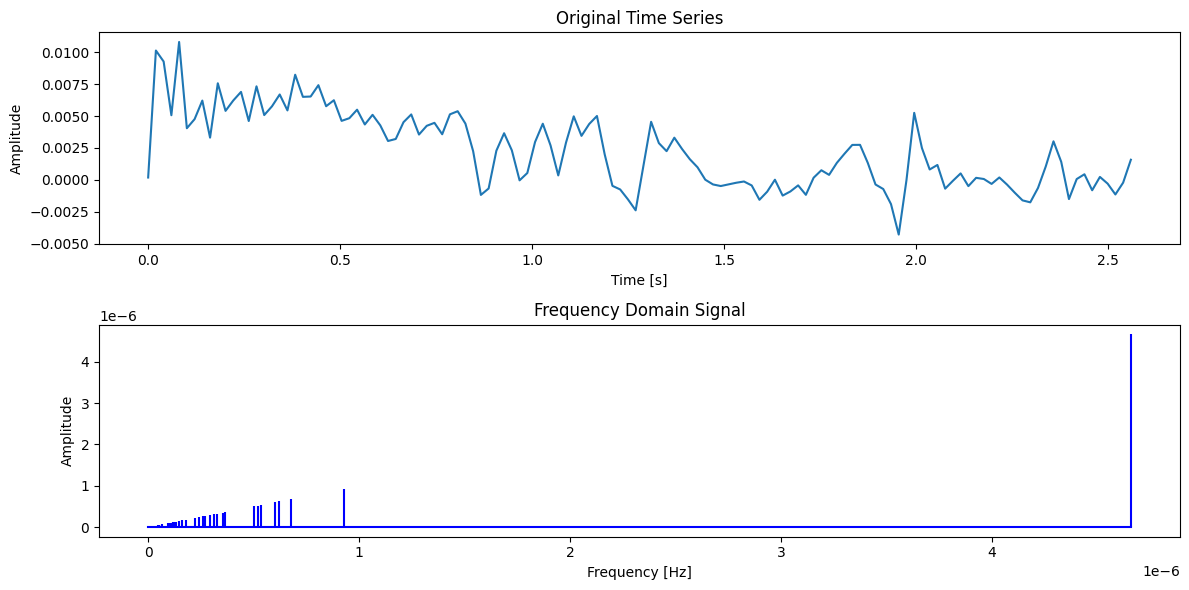

In [7]:
# Exploring conversion to frequency domain
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
# According to documentation of the dataset each window is 2.56s long
t = np.linspace(0.0, 2.56, 128)

sample_rate = 128 / 2.56

# Apply Welch's method
frequencies, power = welch(train_data[0, :, 0], fs=sample_rate, nperseg=128)

# Plot the original signal
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(t, train_data[0,:,0])
plt.title('Original Time Series')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

# Plot the Power Density Spectrum of the signal
plt.subplot(2, 1, 2)
plt.stem(power, np.abs(power), 'b', markerfmt=" ", basefmt="-b")
plt.title('Frequency Domain Signal')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')
plt.tight_layout()

plt.show()

frequency_bins = power.shape[0]

In [8]:
def apply_welch(data: np.ndarray, n_time_steps: int, sample_rate: float, frequency_bins: int) -> np.ndarray:
  import numpy as np
  from scipy.signal import welch

  # Welch's method returns a PSD for each frequency bin
  psd_data = np.zeros((data.shape[0], frequency_bins, data.shape[2]))

  # Apply Welch's method
  for i in range(data.shape[2]):  # iterating over the feature dimension
      frequencies, power = welch(data[:, :, i], fs=sample_rate, nperseg=n_time_steps)
      psd_data[:, :, i] = power

  return psd_data


In [9]:
train_data_psd = apply_welch(
    data=train_data,
    n_time_steps=n_time_steps,
    sample_rate=sample_rate,
    frequency_bins=frequency_bins
)
test_data_psd = apply_welch(
    data=test_data,
    n_time_steps=n_time_steps,
    sample_rate=sample_rate,
    frequency_bins=frequency_bins
)

## Defining Metrics

In [10]:
def print_metrics(predicted_classes: np.ndarray[int], original_classes: np.ndarray[int]) -> None:
  from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
  # Accuracy
  accuracy = accuracy_score(original_classes, predicted_classes)
  print(f'Accuracy: {accuracy:.2f}')

  # Confusion matrix
  conf_matrix = confusion_matrix(original_classes, predicted_classes)
  print(f'Confusion Matrix:\n{conf_matrix}')

  # Precision, recall, and F1 score for each class
  precision = [f'{class_precision:.2f}' for class_precision in precision_score(original_classes, predicted_classes, average=None, zero_division=0)]
  recall = [f'{class_recall:.2f}' for class_recall in recall_score(original_classes, predicted_classes, average=None, zero_division=0)]
  f1 = [f'{class_f1:.2f}' for class_f1 in f1_score(original_classes, predicted_classes, average=None, zero_division=0)]

  print(f'Precision per class: {", ".join(precision)}')
  print(f'Recall per class: {", ".join(recall)}')
  print(f'F1 Score per class: {", ".join(f1)}')

  # Single precision, recall and f1 score
  precision_macro = precision_score(original_classes, predicted_classes, average='macro', zero_division=0)
  recall_macro = recall_score(original_classes, predicted_classes, average='macro', zero_division=0)
  f1_macro = f1_score(original_classes, predicted_classes, average='macro', zero_division=0)

  print(f'Macro Precision: {precision_macro:.2f}')
  print(f'Macro Recall: {recall_macro:.2f}')
  print(f'Macro F1 Score: {f1_macro:.2f}')

In [11]:
def plot_accuracy_per_epoch(model_history) -> None:
  import matplotlib.pyplot as plt
  import tensorflow as tf

  # Extracting accuracies
  train_acc = model_history.history['accuracy']
  test_acc = model_history.history['val_accuracy']
  epochs = range(1, len(train_acc) + 1)

  # Plotting
  plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
  plt.plot(epochs, test_acc, 'ro-', label='Testing Accuracy')
  plt.title('Training and Testing Accuracy per Epoch')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.show()

# CNN+LSTM

## Creating the Model

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense

# Model Definition
model = Sequential([
    # Convolutional layer
    Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=(frequency_bins, n_features)),
    MaxPooling1D(pool_size=2),
    # LSTM layer
    LSTM(32),
    # Fully connected layer
    Dense(32, activation='relu'),
    Dense(n_classes, activation='softmax')
])

# Model compilation
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 64, 32)            608       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 32, 32)           0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dense_1 (Dense)             (None, 6)                 198       
                                                                 
Total params: 10,182
Trainable params: 10,182
Non-trainable params: 0
____________________________________________________

## Testing the Model

In [13]:
# Model compilation
history = model.fit(train_data_psd, train_labels, epochs=10, batch_size=32, validation_split=0.2)

# Predictions with test data
predictions = model.predict(test_data_psd)

# Class with highest probability
predicted_classes = np.argmax(predictions, axis=1)
predicted_classes += 1

Epoch 1/10
184/184 [==============================] - 9s 34ms/step - loss: 1.4099 - accuracy: 0.2777 - val_loss: 1.1347 - val_accuracy: 0.3453
Epoch 2/10
184/184 [==============================] - 6s 30ms/step - loss: 1.1300 - accuracy: 0.3350 - val_loss: 1.1242 - val_accuracy: 0.3542
Epoch 3/10
184/184 [==============================] - 4s 21ms/step - loss: 1.1275 - accuracy: 0.3476 - val_loss: 1.1186 - val_accuracy: 0.3351
Epoch 4/10
184/184 [==============================] - 4s 21ms/step - loss: 1.1979 - accuracy: 0.3273 - val_loss: 1.1164 - val_accuracy: 0.3297
Epoch 5/10
184/184 [==============================] - 6s 31ms/step - loss: 1.1248 - accuracy: 0.3629 - val_loss: 1.0962 - val_accuracy: 0.3698
Epoch 6/10
184/184 [==============================] - 6s 30ms/step - loss: 1.4209 - accuracy: 0.2955 - val_loss: 1.7869 - val_accuracy: 0.1829
Epoch 7/10
184/184 [==============================] - 4s 22ms/step - loss: 1.7856 - accuracy: 0.1932 - val_loss: 1.7858 - val_accuracy: 0.1829

In [14]:
print_metrics(predicted_classes, original_classes)

Accuracy: 0.35
Confusion Matrix:
[[485   0   0   0   0  11]
 [471   0   0   0   0   0]
 [420   0   0   0   0   0]
 [  2   0   0   0   0 489]
 [  5   0   0   0   0 527]
 [  1   0   0   0   0 536]]
Precision per class: 0.35, 0.00, 0.00, 0.00, 0.00, 0.34
Recall per class: 0.98, 0.00, 0.00, 0.00, 0.00, 1.00
F1 Score per class: 0.52, 0.00, 0.00, 0.00, 0.00, 0.51
Macro Precision: 0.12
Macro Recall: 0.33
Macro F1 Score: 0.17


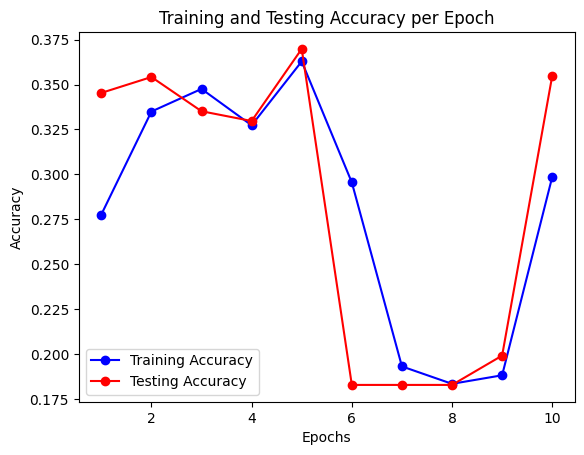

In [15]:
plot_accuracy_per_epoch(history)

# CNN+LSTM Improved

## Creating the Model

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, LSTM, Dropout

# Model Definition
cnn_model = Sequential([
    # Convolutional layer
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(frequency_bins, n_features)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    # LSTM layer
    LSTM(64),
    # Fully connected layer
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(n_classes, activation='softmax')
])

# Model compilation
cnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Summary
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 63, 64)            1792      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 31, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 29, 128)           24704     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 14, 128)          0         
 1D)                                                             
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense_2 (Dense)             (None, 64)               

## Testing the Model

In [17]:
# Model training
cnn_history = cnn_model.fit(train_data_psd, train_labels, epochs=10, batch_size=32, validation_split=0.2)

# Predictions with test data
cnn_predictions = cnn_model.predict(test_data_psd)

# Class with highest probability
cnn_predicted_classes = np.argmax(cnn_predictions, axis=1)
cnn_predicted_classes += 1

Epoch 1/10
184/184 [==============================] - 9s 35ms/step - loss: 1.2867 - accuracy: 0.3397 - val_loss: 0.9857 - val_accuracy: 0.4507
Epoch 2/10
184/184 [==============================] - 7s 39ms/step - loss: 1.0138 - accuracy: 0.4470 - val_loss: 0.8581 - val_accuracy: 0.5058
Epoch 3/10
184/184 [==============================] - 5s 28ms/step - loss: 0.8939 - accuracy: 0.5191 - val_loss: 0.7004 - val_accuracy: 0.5935
Epoch 4/10
184/184 [==============================] - 5s 28ms/step - loss: 0.7603 - accuracy: 0.5873 - val_loss: 0.7200 - val_accuracy: 0.6037
Epoch 5/10
184/184 [==============================] - 8s 43ms/step - loss: 0.7111 - accuracy: 0.6026 - val_loss: 0.6438 - val_accuracy: 0.6152
Epoch 6/10
184/184 [==============================] - 5s 25ms/step - loss: 0.6723 - accuracy: 0.6213 - val_loss: 0.6301 - val_accuracy: 0.6343
Epoch 7/10
184/184 [==============================] - 5s 27ms/step - loss: 0.6753 - accuracy: 0.6195 - val_loss: 0.6358 - val_accuracy: 0.6145

In [18]:
print_metrics(cnn_predicted_classes, original_classes)

Accuracy: 0.62
Confusion Matrix:
[[469   0  22   0   1   4]
 [  7 413  51   0   0   0]
 [  2   2 416   0   0   0]
 [  0   0   0   0 490   1]
 [  1   0   0   0 530   1]
 [  1   0   0   0 536   0]]
Precision per class: 0.98, 1.00, 0.85, 0.00, 0.34, 0.00
Recall per class: 0.95, 0.88, 0.99, 0.00, 1.00, 0.00
F1 Score per class: 0.96, 0.93, 0.92, 0.00, 0.51, 0.00
Macro Precision: 0.53
Macro Recall: 0.63
Macro F1 Score: 0.55


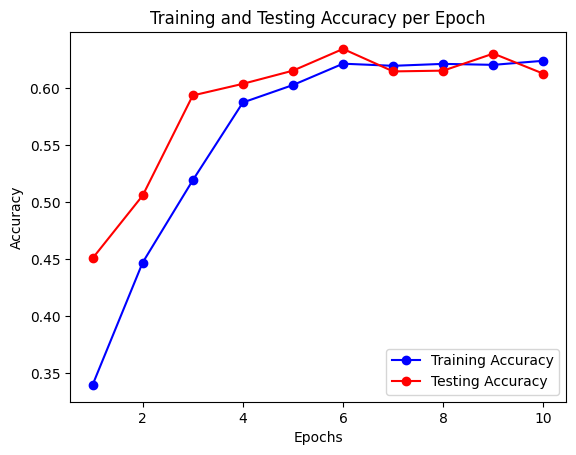

In [19]:
plot_accuracy_per_epoch(cnn_history)

# GRU

## Creating Model

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout

# Model Definition
gru_model = Sequential([
    # GRU layer
    GRU(128, input_shape=(frequency_bins, n_features), return_sequences=True),
    Dropout(0.5),
    GRU(64, return_sequences=False),
    Dropout(0.5),
    # Fully connected layer
    Dense(64, activation='relu'),
    Dense(n_classes, activation='softmax')
])

# Model compilation
gru_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary
gru_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 65, 128)           53376     
                                                                 
 dropout_1 (Dropout)         (None, 65, 128)           0         
                                                                 
 gru_1 (GRU)                 (None, 64)                37248     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 6)                 390       
                                                                 
Total params: 95,174
Trainable params: 95,174
Non-trai

## Testing Model

In [21]:
# Model training
gru_history = gru_model.fit(train_data_psd, train_labels, epochs=10, batch_size=32, validation_split=0.2)

# Predictions with test data
gru_predictions = gru_model.predict(test_data_psd)

# Class with highest probability
gru_predicted_classes = np.argmax(gru_predictions, axis=1)
gru_predicted_classes += 1

Epoch 1/10
184/184 [==============================] - 40s 194ms/step - loss: 1.7877 - accuracy: 0.1813 - val_loss: 1.7834 - val_accuracy: 0.1992
Epoch 2/10
184/184 [==============================] - 27s 145ms/step - loss: 1.7860 - accuracy: 0.1818 - val_loss: 1.7875 - val_accuracy: 0.1992
Epoch 3/10
184/184 [==============================] - 31s 168ms/step - loss: 1.7863 - accuracy: 0.1920 - val_loss: 1.7851 - val_accuracy: 0.1795
Epoch 4/10
184/184 [==============================] - 27s 145ms/step - loss: 1.7854 - accuracy: 0.1910 - val_loss: 1.7846 - val_accuracy: 0.1992
Epoch 5/10
184/184 [==============================] - 31s 170ms/step - loss: 1.7860 - accuracy: 0.1877 - val_loss: 1.7866 - val_accuracy: 0.1829
Epoch 6/10
184/184 [==============================] - 27s 149ms/step - loss: 1.7854 - accuracy: 0.1774 - val_loss: 1.7830 - val_accuracy: 0.1992
Epoch 7/10
184/184 [==============================] - 32s 173ms/step - loss: 1.6617 - accuracy: 0.2270 - val_loss: 1.1168 - val_ac

In [22]:
print_metrics(gru_predicted_classes, original_classes)

Accuracy: 0.37
Confusion Matrix:
[[203 151 142   0   0   0]
 [286 136  49   0   0   0]
 [152  45 223   0   0   0]
 [  0   2   0   0   0 489]
 [  0   6   0   0   1 525]
 [  0   1   0   0   0 536]]
Precision per class: 0.32, 0.40, 0.54, 0.00, 1.00, 0.35
Recall per class: 0.41, 0.29, 0.53, 0.00, 0.00, 1.00
F1 Score per class: 0.36, 0.33, 0.53, 0.00, 0.00, 0.51
Macro Precision: 0.43
Macro Recall: 0.37
Macro F1 Score: 0.29


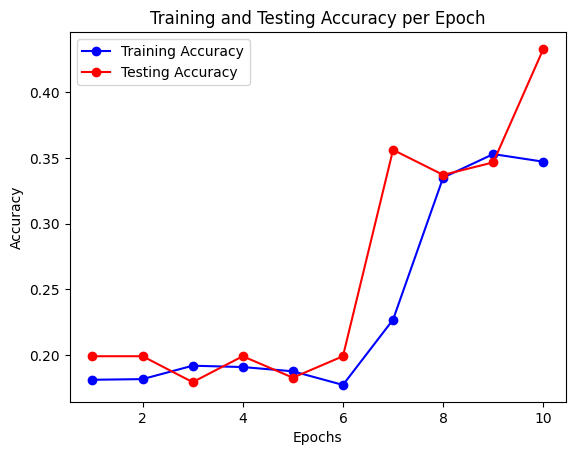

In [23]:
plot_accuracy_per_epoch(gru_history)

# CNN-GRU

## Creating Model

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GRU, Dense, Dropout, Flatten

# Model Definition
cnn_gru_model = Sequential([
    # Convolutional layer
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(frequency_bins, n_features)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    # GRU layer
    GRU(64, return_sequences=True),
    Dropout(0.5),
    GRU(64, return_sequences=False),
    Dropout(0.5),
    # Fully connected layer
    Dense(64, activation='relu'),
    Dense(n_classes, activation='softmax')
])

# Model compilation
cnn_gru_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary
cnn_gru_model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 63, 64)            1792      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 31, 64)           0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 29, 128)           24704     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 14, 128)          0         
 1D)                                                             
                                                                 
 gru_2 (GRU)                 (None, 14, 64)            37248     
                                                                 
 dropout_3 (Dropout)         (None, 14, 64)           

## Testing Model

In [25]:
# Model training
cnn_gru_history = cnn_gru_model.fit(train_data_psd, train_labels, epochs=10, batch_size=32, validation_split=0.2)

# Predictions with test data
cnn_gru_predictions = cnn_gru_model.predict(test_data_psd)

# Class with highest probability
cnn_gru_predicted_classes = np.argmax(cnn_gru_predictions, axis=1)
cnn_gru_predicted_classes += 1

Epoch 1/10
184/184 [==============================] - 16s 51ms/step - loss: 1.3351 - accuracy: 0.3071 - val_loss: 1.0535 - val_accuracy: 0.4432
Epoch 2/10
184/184 [==============================] - 9s 49ms/step - loss: 1.0161 - accuracy: 0.4300 - val_loss: 0.8137 - val_accuracy: 0.5438
Epoch 3/10
184/184 [==============================] - 9s 50ms/step - loss: 0.8714 - accuracy: 0.5372 - val_loss: 0.7126 - val_accuracy: 0.5860
Epoch 4/10
184/184 [==============================] - 8s 42ms/step - loss: 0.7604 - accuracy: 0.5914 - val_loss: 0.6624 - val_accuracy: 0.6077
Epoch 5/10
184/184 [==============================] - 10s 56ms/step - loss: 0.6967 - accuracy: 0.6142 - val_loss: 0.6410 - val_accuracy: 0.6132
Epoch 6/10
184/184 [==============================] - 7s 39ms/step - loss: 0.6719 - accuracy: 0.6130 - val_loss: 0.6781 - val_accuracy: 0.6186
Epoch 7/10
184/184 [==============================] - 11s 62ms/step - loss: 0.6581 - accuracy: 0.6235 - val_loss: 0.6941 - val_accuracy: 0.6

In [26]:
print_metrics(cnn_gru_predicted_classes, original_classes)

Accuracy: 0.64
Confusion Matrix:
[[480  10   3   0   0   3]
 [  0 460  11   0   0   0]
 [  2  16 402   0   0   0]
 [  0   1   0   0   0 490]
 [  2   0   0   0   0 530]
 [  0   0   0   0   0 537]]
Precision per class: 0.99, 0.94, 0.97, 0.00, 0.00, 0.34
Recall per class: 0.97, 0.98, 0.96, 0.00, 0.00, 1.00
F1 Score per class: 0.98, 0.96, 0.96, 0.00, 0.00, 0.51
Macro Precision: 0.54
Macro Recall: 0.65
Macro F1 Score: 0.57


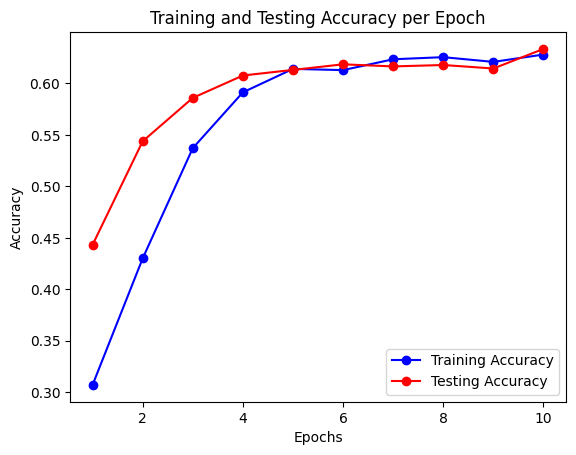

In [27]:
plot_accuracy_per_epoch(cnn_gru_history)